## Denoising by spectrogram





Pour ce projet vous avez :

Pour le train
- Un dossier contenant des fichiers d'enregistrements de voix sans bruit (audio/voice_origin/train)
- Un dossier contenant des fichiers d'enregistrements de voix avec une ambiance de rue en arrière-plan (audio/denoising/train)
La correspondance entre un enregistrement avec ambiance et l'enregistrement parfait de la voix se fait via le nom des fichiers.

Pour l'ensemble de test vous avez deux ensembles de fichiers similaires.

Dans audio/voice_origin et audio/denoising vous avec un dossier train_small de petite taille que vous pouvez télécharger rapidement pour faire des essai.

L'objectif est d'estimer à partir du signal bruité le signal de voix.

Les signaux ont un SNR (Signal to Noise Ratio) compris entre 0 et 20 dB.

Vous pouvez au choix travailler
- sur le spectrogramme par exemple en vous des approches par masquage présentés dans le cours 09 et en estimant les masques avec un réseau Seq2Seq de votre choix ou un UNet (cf A. Jansson et Al., SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017 )
- directement sur la forme d'onde  :
   - cf D. Stoller  et Al., WAVE-U-NET: A MULTI-SCALE NEURAL NETWORK FOR END-TO-END AUDIO SOURCE SEPARATION, ISMIR 2018
   - les apporches TAS NEt : Y. Luo et Al., TaSNet: Time-Domain Audio Separation Network for Real-Time, Single-Channel Speech Separation, ICASSP 2018 ou Y. Luo et Al.,  Conv-tasnet: surpassing ideal time–frequency magnitude masking for speech separation. IEEE/ACM Transactions on Audio, Speech, and Language Processing, 2019.


Libre à vous de choisir la fonction de perte utilisée dans l’entraînement et adaptée au format des données que vous utiliserez en entrée du réseau de neurones.

Pour l'évaluation des performances sur l'ensemble de test, outre la fonction de perte vous vous intéresserez au PESQ et au STOI des voix estimées.  


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

In [ ]:
!mkdir denoising
!unzip drive/MyDrive/MVA/DeepSignal/denoising/test.zip -d denoising > /dev/null 2>&1
!unzip drive/MyDrive/MVA/DeepSignal/denoising/train.zip -d denoising > /dev/null 2>&1
!unzip drive/MyDrive/MVA/DeepSignal/denoising/train_small.zip -d denoising > /dev/null 2>&1
!mkdir voice_origin
!unzip drive/MyDrive/MVA/DeepSignal/voice_origin/test.zip -d voice_origin > /dev/null 2>&1
!unzip drive/MyDrive/MVA/DeepSignal/voice_origin/train.zip -d voice_origin > /dev/null 2>&1
!unzip drive/MyDrive/MVA/DeepSignal/voice_origin/train_small.zip -d voice_origin > /dev/null 2>&1

In [5]:
path = "/"

In [ ]:
!pip install pySTOI
!pip install pesq

In [7]:
import os
import sys
import numpy as np
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import scipy
from scipy.signal import stft, istft
import IPython.display as ipd
import torchaudio
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.io import wavfile
from scipy.io import wavfile
from pystoi import stoi
from pesq import pesq
import soundfile as sf
import time

## Visualisation

In [8]:
rate, data = scipy.io.wavfile.read('/content/denoising/test/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap03_0_.wav')
ipd.Audio(data, rate=rate)

In [9]:
# STFT parameters
window_size = 1024  # Window size
hop_length = 768    # Hop length
patch_size = 128    # Patch size
noverlap = window_size - hop_length

In [10]:
def audioToSpectro(audio_signal, fs, nperseg=1024, noverlap=None):
    """
    Convert an audio signal to a spectrogram.

    :param audio_signal: List of floats - the audio signal.
    :param fs: Sampling rate of the audio signal.
    :param nperseg: Length of each segment for STFT.
    :param noverlap: Number of points to overlap between segments.
    :return: A tuple of frequency bins, time bins, and the spectrogram.
    """
    f, t, Zxx = stft(audio_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
    spectrogram = np.abs(Zxx)
    spectrogram = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))
    phase = np.angle(Zxx)
    return f, t, spectrogram, phase

def SpectroToAudio(spectrogram, phase, fs, nperseg=1024, noverlap=None):
    Zxx = spectrogram * np.exp(1j * phase)
    _, x_reconstructed = istft(Zxx, fs=fs, nperseg=nperseg, noverlap=noverlap)
    return x_reconstructed

# Example usage
f, t, spectrogram, phase = audioToSpectro(data, rate, nperseg=window_size, noverlap=noverlap)
reconstructed_audio = SpectroToAudio(spectrogram, phase, rate, nperseg=window_size, noverlap=noverlap)
ipd.Audio(reconstructed_audio, rate=rate)

## Data

In [12]:
class SpectoDenoisingDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, n_splits):
        self.noisy_files = [os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir) if f.endswith('.wav')]
        self.clean_files = [os.path.join(clean_dir, f) for f in os.listdir(clean_dir) if f.endswith('.wav')]
        assert len(self.noisy_files) == len(self.clean_files), "Mismatch in dataset size"
        self.n_splits = n_splits

    def __len__(self):
        return len(self.noisy_files) * self.n_splits

    def __getitem__(self, idx):
        original_idx = idx // self.n_splits
        split_idx = idx % self.n_splits

        noisy_rate, noisy_waveform = wavfile.read(self.noisy_files[original_idx])
        clean_rate, clean_waveform = wavfile.read(self.clean_files[original_idx])

        waveform_length = len(noisy_waveform)
        split_length = waveform_length // self.n_splits
        start_idx = split_length * split_idx
        end_idx = start_idx + split_length

        noisy_split = noisy_waveform[start_idx:end_idx]
        clean_split = clean_waveform[start_idx:end_idx]

        # Convert clean waveform to float32
        clean_split = clean_split.astype(np.float32)
        noisy_split = noisy_split.astype(np.float32)

        f, t, noisy_spectro, noisy_phase = audioToSpectro(noisy_split, fs=noisy_rate, nperseg=window_size, noverlap=noverlap)
        f, t, clean_spectro, clean_phase = audioToSpectro(clean_split, fs=clean_rate, nperseg=window_size, noverlap=noverlap)

        return f, t, noisy_spectro, clean_spectro, noisy_phase, clean_phase

In [13]:
train_spectro_dataset = SpectoDenoisingDataset('denoising/train/', 'voice_origin/train/', 1)
test_spectro_dataset = SpectoDenoisingDataset('denoising/test/', 'voice_origin/test/', 1)
train_spectro_loader = DataLoader(train_spectro_dataset, batch_size=16, shuffle=True)
test_spectro_loader = DataLoader(test_spectro_dataset, batch_size=16, shuffle=False)

Batch 0:
  Input shape: torch.Size([16, 513, 106])
  Label shape: torch.Size([16, 513, 106])


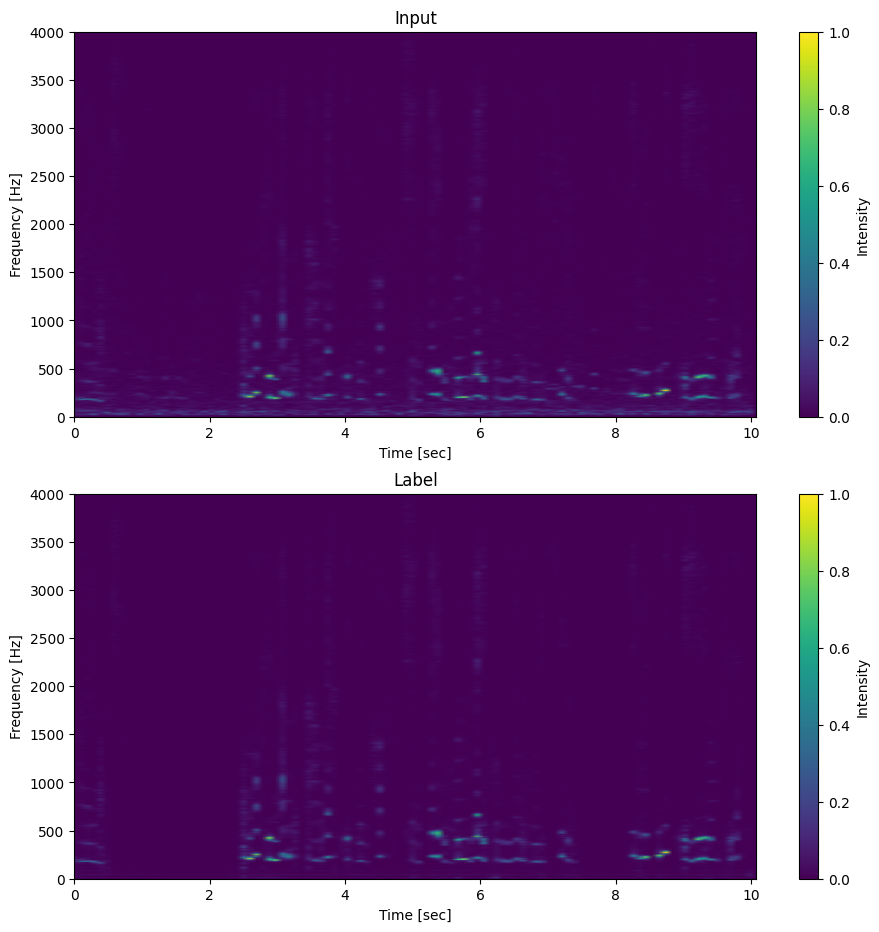

In [14]:
for i, (f, t, inputs, labels, phase, _) in enumerate(train_spectro_loader):
    print(f"Batch {i}:")
    print("  Input shape:", inputs.shape)
    print("  Label shape:", labels.shape)
    plt.figure(figsize=(11,11))
    plt.subplot(211)
    plt.title("Input")
    plt.pcolormesh(t[0], f[0], inputs[0], shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity')
    plt.subplot(212)
    plt.title("Label")
    plt.pcolormesh(t[0], f[0], labels[0], shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity')
    plt.show()
    if i == 0:  # Just to check the first batch as an example
        break

## Models

In [15]:
class UNet2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = (5, 5), stride=(2, 2), padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = (5, 5), stride=(2, 2), padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = (5, 5), stride=(2, 2), padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = (5, 5), stride=(2, 2), padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = (5, 5), stride=(2, 2), padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = (5, 5), stride=(2, 2), padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size = (5, 5), stride=(2, 2), padding=2)
        self.deconv1_BAD = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout2d(0.5)
        )
        self.deconv2 = nn.ConvTranspose2d(512, 128, kernel_size = (5, 5), stride=(2, 2), padding=2)
        self.deconv2_BAD = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout2d(0.5)
        )
        self.deconv3 = nn.ConvTranspose2d(256, 64, kernel_size = (5, 5), stride=(2, 2), padding=2)
        self.deconv3_BAD = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout2d(0.5)
        )
        self.deconv4 = nn.ConvTranspose2d(128, 32, kernel_size = (5, 5), stride=(2, 2), padding=2)
        self.deconv4_BAD = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        self.deconv5 = nn.ConvTranspose2d(64, 16, kernel_size = (5, 5), stride=(2, 2), padding=2)
        self.deconv5_BAD = nn.Sequential(
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )
        self.deconv6 = nn.ConvTranspose2d(32, 1, kernel_size = (5, 5), stride=(2, 2), padding=2)

    def forward(self, input):
        conv1_out = self.conv1(input)
        conv2_out = self.conv2(conv1_out)
        conv3_out = self.conv3(conv2_out)
        conv4_out = self.conv4(conv3_out)
        conv5_out = self.conv5(conv4_out)
        conv6_out = self.conv6(conv5_out)
        deconv1_out = self.deconv1(conv6_out, output_size = conv5_out.size())
        deconv1_out = self.deconv1_BAD(deconv1_out)
        deconv2_out = self.deconv2(torch.cat([deconv1_out, conv5_out], 1), output_size = conv4_out.size())
        deconv2_out = self.deconv2_BAD(deconv2_out)
        deconv3_out = self.deconv3(torch.cat([deconv2_out, conv4_out], 1), output_size = conv3_out.size())
        deconv3_out = self.deconv3_BAD(deconv3_out)
        deconv4_out = self.deconv4(torch.cat([deconv3_out, conv3_out], 1), output_size = conv2_out.size())
        deconv4_out = self.deconv4_BAD(deconv4_out)
        deconv5_out = self.deconv5(torch.cat([deconv4_out, conv2_out], 1), output_size = conv1_out.size())
        deconv5_out = self.deconv5_BAD(deconv5_out)
        deconv6_out = self.deconv6(torch.cat([deconv5_out, conv1_out], 1), output_size = input.size())
        out = F.sigmoid(deconv6_out)
        return out*input


## Pipelines

In [16]:
def train(model, train_loader, optimizer, criterion):
    model.train()  # Set the model to training mode
    total_loss = 0

    for _, _, inputs, targets, _, _ in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move to device and ensure the data type matches the model

        inputs = inputs.unsqueeze(1)[:,:,:512,:128]
        targets = targets.unsqueeze(1)[:,:,:512,:128]
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    return average_loss

In [17]:
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # No need to track the gradients
        for _, _, inputs, targets, _, _ in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.unsqueeze(1)[:, :, :512, :128]
            targets = targets.unsqueeze(1)[:, :, :512, :128]

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()

    average_loss = total_loss / len(val_loader)
    return average_loss

## Training

Epoch 1/50 - time: 35.06088066101074- Training Loss: 0.00001494, Validation Loss: 0.00003203
Validation loss improved from inf to 0.00003203. Saving model...
Epoch 2/50 - time: 70.68791460990906- Training Loss: 0.00001175, Validation Loss: 0.00001450
Validation loss improved from 0.00003203 to 0.00001450. Saving model...
Epoch 3/50 - time: 105.06085419654846- Training Loss: 0.00001111, Validation Loss: 0.00001294
Validation loss improved from 0.00001450 to 0.00001294. Saving model...
Epoch 4/50 - time: 139.7492847442627- Training Loss: 0.00001065, Validation Loss: 0.00001204
Validation loss improved from 0.00001294 to 0.00001204. Saving model...
Epoch 5/50 - time: 175.04017901420593- Training Loss: 0.00001011, Validation Loss: 0.00001139
Validation loss improved from 0.00001204 to 0.00001139. Saving model...
Epoch 6/50 - time: 209.35483264923096- Training Loss: 0.00000949, Validation Loss: 0.00001094
Validation loss improved from 0.00001139 to 0.00001094. Saving model...
Epoch 7/50 - t

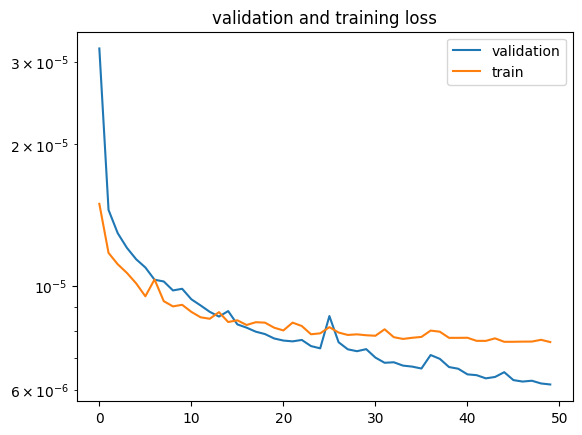

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming unet_model is your U-Net model
model = UNet2D().to(device)

# Choose an appropriate loss function
criterion = nn.MSELoss()  # Example for a regression task like denoising

val_loss_history, train_loss_history = [], []
# Select an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50  # Number of epochs
best_val_loss = float('inf')  # Initialize best validation loss as infinity
start_time=time.time()
for epoch in range(epochs):
    val_loss_history.append(train(model, train_spectro_loader, optimizer, criterion))
    train_loss_history.append(validate(model, test_spectro_loader, criterion))
    print(f"Epoch {epoch+1}/{epochs} - time: {time.time()-start_time}- Training Loss: {train_loss_history[-1]:.8f}, Validation Loss: {val_loss_history[-1]:.8f}")
    # Save the model if the validation loss improved
    if val_loss_history[-1] < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.8f} to {val_loss_history[-1]:.8f}. Saving model...")
        best_val_loss = val_loss_history[-1]
        torch.save(model.state_dict(), 'best_denoise_unet.pt')

plt.plot(val_loss_history, label='validation')
plt.plot(train_loss_history, label='train')
plt.yscale("log")
plt.legend()
plt.title("validation and training loss")
plt.show()

## Results

### General analysis of the results

In [64]:
model = UNet2D().to(device)
model.load_state_dict(torch.load('best_denoise_unet.pt'))

<All keys matched successfully>

In [65]:
def pad_array(input_array):
    # Get the dimensions of the input array
    input_shape = input_array.shape

    # Calculate the amount of padding required for each dimension
    pad_height = 513 - input_shape[0]
    pad_width = 158 - input_shape[1]

    # Create a zero-padded array with the target shape
    padded_array = np.pad(input_array, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

    return padded_array

In [66]:
stoi_originals,stoi_preds, pesq_originals, pesq_preds = [], [], [], []
pred_signals, pred_spectro = [], []
target_signals, target_spectro = [], []
input_signals, input_spectro = [], []
stop = -1
for idx, (f, t, inputs, targets, phase, true_phase)  in enumerate(test_spectro_loader):
    if idx==stop:
        break
    inputs = inputs.unsqueeze(1)[:,:,:512,:128]
    targets = targets.unsqueeze(1)
    inputs = inputs.to(device)
    with torch.no_grad():
        prediction_spectro = model(inputs)
        predic = prediction_spectro.cpu()
        real = targets.cpu()
        origin = inputs.cpu()
        phas = phase.cpu()
        true_phas = true_phase.cpu()
        for p, r, o, ph, tr_ph in zip(predic.numpy(), real.numpy(), origin.numpy(), phas.numpy(), true_phas.numpy()):
            p = pad_array(p[0])
            p = np.clip(p, 0, 1)
            o = pad_array(o[0])
            r = r[0]
            predict_audio = SpectroToAudio(p[:,:106], ph, rate, nperseg=window_size, noverlap=noverlap)
            original_audio = SpectroToAudio(o[:, :106], ph, rate, nperseg=window_size, noverlap=noverlap)
            true_audio = SpectroToAudio(r, tr_ph, rate, nperseg=window_size, noverlap=noverlap)
            stoi_originals.append(stoi(true_audio, original_audio, rate))
            stoi_preds.append(stoi(true_audio, predict_audio[:len(true_audio)], rate))
            pesq_originals.append(pesq(rate, true_audio, original_audio, 'nb'))
            pesq_preds.append(pesq(rate, true_audio, predict_audio[:len(true_audio)], 'nb'))

            target_signals.append(true_audio)
            target_spectro.append(r)
            pred_signals.append(predict_audio)
            pred_spectro.append(p)
            input_signals.append(original_audio)
            input_spectro.append(o)

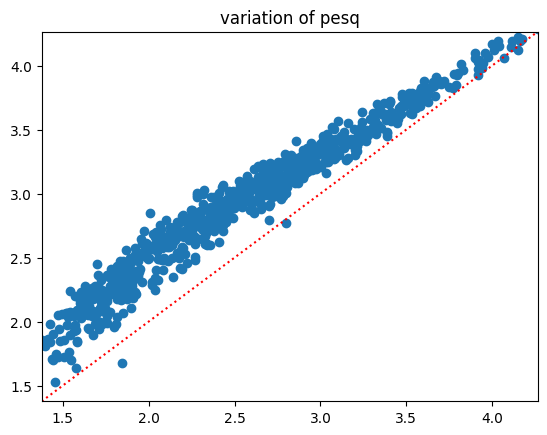

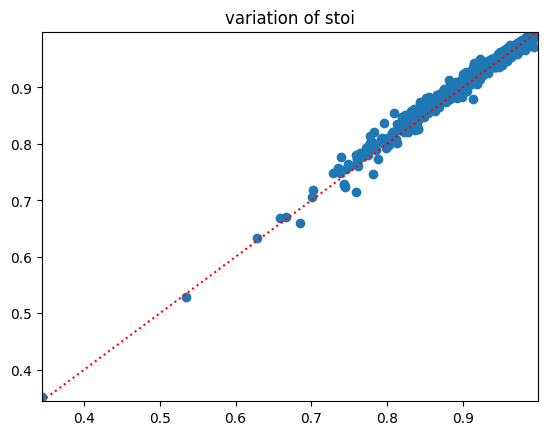

In [67]:
plt.title("variation of pesq")
plt.scatter(pesq_originals, pesq_preds)
plt.xlim(np.min(pesq_originals), np.max(pesq_originals))
plt.ylim(np.min(pesq_originals),np.max(pesq_originals))
plt.plot([min(pesq_originals), max(pesq_originals)], [min(pesq_originals), max(pesq_originals)], color='red', linestyle=':', label='Identity Line')
plt.show()

plt.title("variation of stoi")
plt.scatter(stoi_originals, stoi_preds)
plt.xlim(np.min(stoi_originals), np.max(stoi_originals))
plt.ylim(np.min(stoi_originals),np.max(stoi_originals))
plt.plot([min(stoi_originals), max(stoi_originals)], [min(stoi_originals), max(stoi_originals)], color='red', linestyle=':', label='Identity Line')
plt.show()

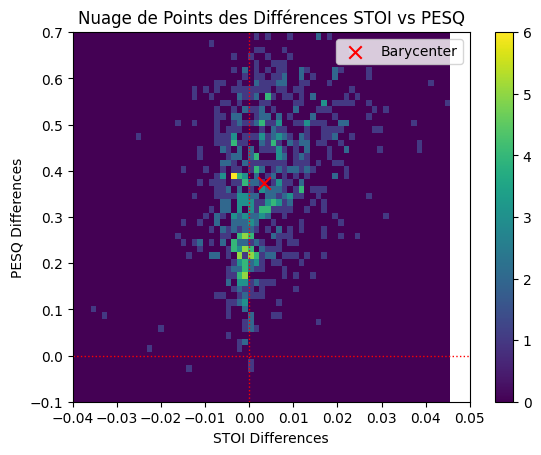

In [68]:
stoi_diffs = [a - b for a, b in zip(stoi_preds, stoi_originals)]  # >0 is better
pesq_diffs = [a - b for a, b in zip(pesq_preds, pesq_originals)]  # >0 is better

plt.hist2d(stoi_diffs, pesq_diffs, bins=(70, 70), cmap='viridis')

# Add colorbar
plt.colorbar()
plt.xlim(-0.04, 0.05)  # Set the x-axis limits
plt.ylim(-0.1, 0.7)  # Set the y-axis limits
# Set labels and title
plt.xlabel('STOI Differences')
plt.ylabel('PESQ Differences')
plt.title('Nuage de Points des Différences STOI vs PESQ')
plt.axhline(0, color='red', linestyle=':', linewidth=1)
plt.axvline(0, color='red', linestyle=':', linewidth=1)
plt.scatter(np.mean(stoi_diffs), np.mean(pesq_diffs), c='red', marker='x', label='Barycenter', s=80)
plt.legend()
# Show the plot
plt.show()

### Example with Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap03_100_

In [69]:
# test for a specific audio
example_file = "Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap03_100_.wav"
rate, data_example = scipy.io.wavfile.read('/content/denoising/test/'+example_file)
_, _, spectro_example, phase_example = audioToSpectro(data_example, fs=rate, nperseg=window_size, noverlap=noverlap)
pred = model(torch.from_numpy(spectro_example)[None, None, :512, :128].to(device))
res_spectro = pad_array(pred.cpu().detach().numpy()[0, 0])
res_audio = SpectroToAudio(res_spectro[:,:106], phase_example, rate, window_size, noverlap)
print("INPUT")
ipd.Audio(data_example, rate=rate)

INPUT


In [70]:
print("PREDICTION")
ipd.Audio(res_audio, rate=rate)

PREDICTION


In [71]:
print("TARGET")
rate, target_example = scipy.io.wavfile.read('/content/voice_origin/test/'+example_file)
_, _, spectro_target_example, _ = audioToSpectro(target_example, fs=rate, nperseg=window_size, noverlap=noverlap)
ipd.Audio(target_example, rate=rate)

TARGET
